In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import numpy as np

In [2]:
dataset = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/tomatoleaf/tomato/train',
    batch_size=32,
    image_size=(256, 256),
    seed=123,
    shuffle=True
)

Found 10000 files belonging to 10 classes.


In [3]:
class_names = dataset.class_names
print(f"Class Names: {class_names}")

Class Names: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [4]:
class_name = dataset.class_names
class_name[3]

'Tomato___Leaf_Mold'

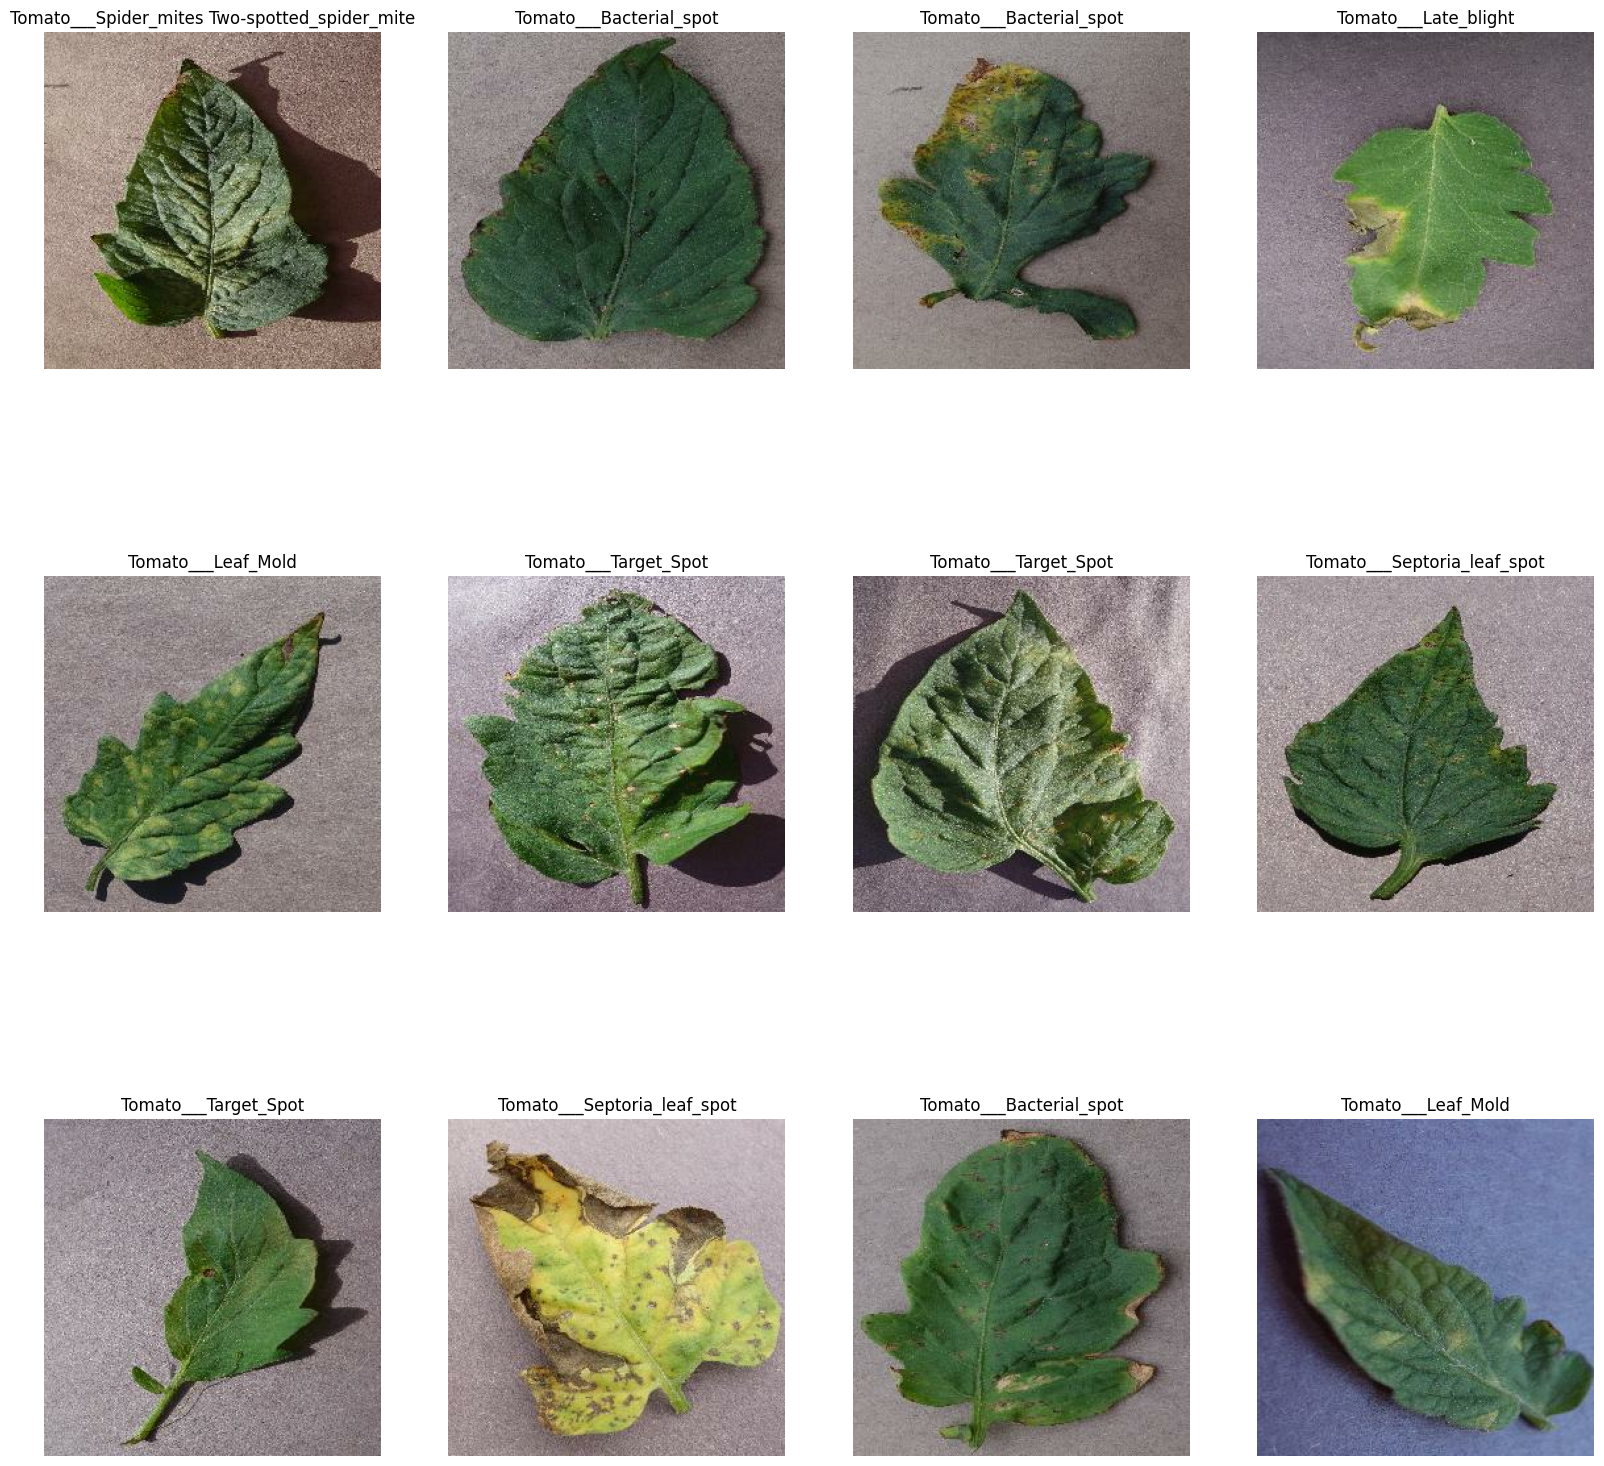

In [5]:
# Visualize some sample images
plt.figure(figsize=(20, 20))
for image, label in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_names[label[i].numpy()])
        plt.axis('OFF')

In [6]:
# Train-test split function
def train_test_split(dataset, train_size=0.8):
    dataset_size = len(dataset)
    train_size = int(train_size * dataset_size)
    train_ds = dataset.take(train_size)
    test_ds = dataset.skip(train_size)
    return train_ds, test_ds

In [7]:
len(dataset)

313

In [8]:
X_train, X_test = train_test_split(dataset)

In [9]:
len(X_train)

250

In [10]:
len(X_test)

63

In [11]:
for image, lable in dataset.take(1):
    print(image[0].numpy().shape)

(256, 256, 3)


In [12]:
# Prefetch and cache datasets
ds_train = X_train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
ds_test = X_test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [13]:
# Define the scaling layer
scaling = tf.keras.Sequential([
    layers.Rescaling(1.0/255)
])


In [14]:
# Define data augmentation layers
data_augmentation = tf.keras.Sequential([
    layers.RandomZoom(0.4),
    layers.RandomRotation(0.1),
    layers.RandomContrast(0.3)
])

In [15]:
model = tf.keras.Sequential([
    scaling,  # Apply scaling
    data_augmentation,  # Apply data augmentation
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    # ANN layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')  # Adjust to number of classes
])

model.build(input_shape=(32, 256, 256, 3))
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 2304)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 128)              │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 10)               │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 426,506 (1.63 MB)

 Trainable params: 426,506 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(ds_train, validation_data=ds_test, batch_size=32, epochs=20)


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 47s 93ms/step - accuracy: 0.1584 - loss: 2.1977 - val_accuracy: 0.3750 - val_loss: 1.7674
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.4033 - loss: 1.6734 - val_accuracy: 0.4555 - val_loss: 1.9962
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - accuracy: 0.5675 - loss: 1.2277 - val_accuracy: 0.5365 - val_loss: 1.7308
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.6779 - loss: 0.9354 - val_accuracy: 0.5230 - val_loss: 1.6479
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.7150 - loss: 0.8074 - val_accuracy: 0.5720 - val_loss: 1.7245
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.7807 - loss: 0.6426 - val_accuracy: 0.5655 - val_loss: 1.8315
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.7880 - loss: 0.5886 - val_accuracy: 0.6685 - val_loss: 1.1676
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.8077 - loss: 0.5500 - 

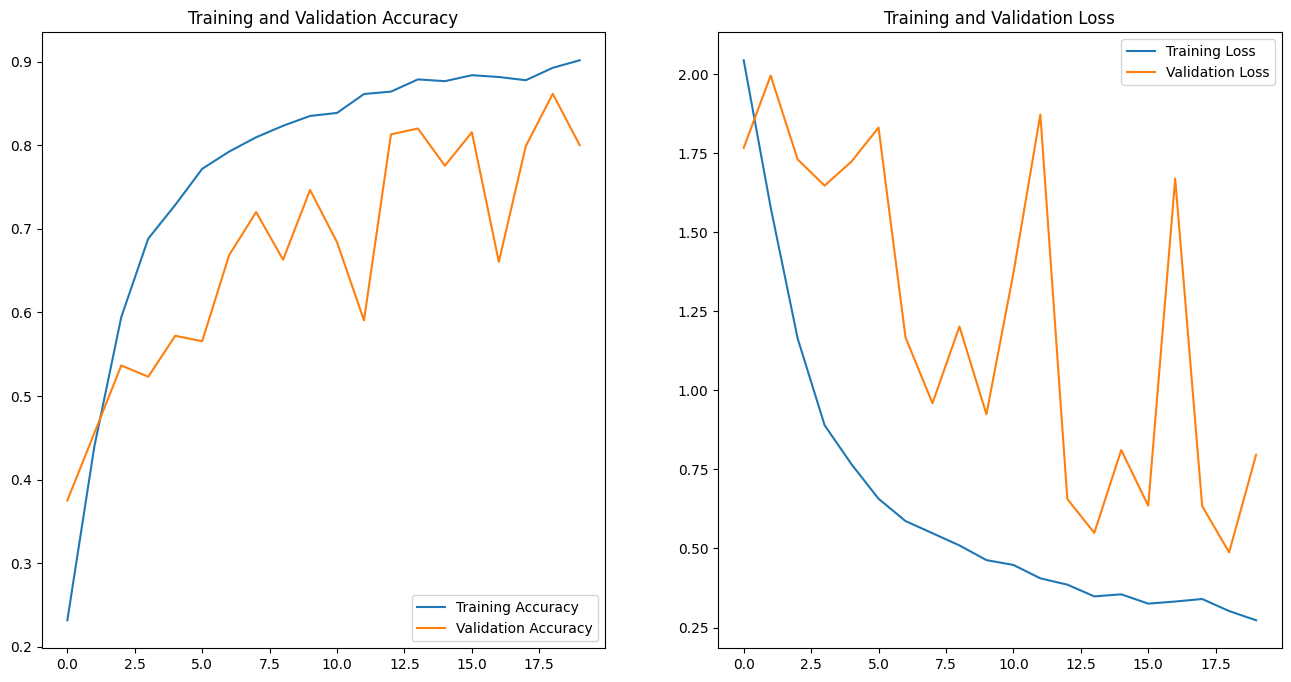

In [18]:
# Plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow as tf

# Path to the uploaded MobileNetV2 weights on Kaggle
weights_path = '/kaggle/input/mobilenet-v2/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5'

# Load the MobileNetV2 model using the uploaded weights
base_model = MobileNetV2(weights=weights_path, include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  # Freeze the base model layers to retain learned features

# Define a new model on top of the MobileNetV2 base
transfer_model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')  # Output layer with number of classes
])

# Compile the model
transfer_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
transfer_history = transfer_model.fit(ds_train, validation_data=ds_test, epochs=20)

# Save the transfer learning model
# transfer_model.save('transfer_model.keras')


Epoch 1/20


I0000 00:00:1726301520.992918     109 service.cc:145] XLA service 0x7dcc981858d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726301520.992964     109 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1726301520.992969     109 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  5/250 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.0769 - loss: 2.6727     

I0000 00:00:1726301526.824591     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 64ms/step - accuracy: 0.4677 - loss: 1.5629 - val_accuracy: 0.7300 - val_loss: 0.8443
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.7205 - loss: 0.8212 - val_accuracy: 0.7680 - val_loss: 0.7089
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.7716 - loss: 0.6838 - val_accuracy: 0.7530 - val_loss: 0.7044
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.7951 - loss: 0.5912 - val_accuracy: 0.7975 - val_loss: 0.5906
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.8191 - loss: 0.5242 - val_accuracy: 0.7890 - val_loss: 0.5577
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.8312 - loss: 0.4924 - val_accuracy: 0.8115 - val_loss: 0.5293
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.8451 - loss: 0.4506 - val_accuracy: 0.8395 - val_loss: 0.4714
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.8566 - loss: 0.4042 - val_accurac

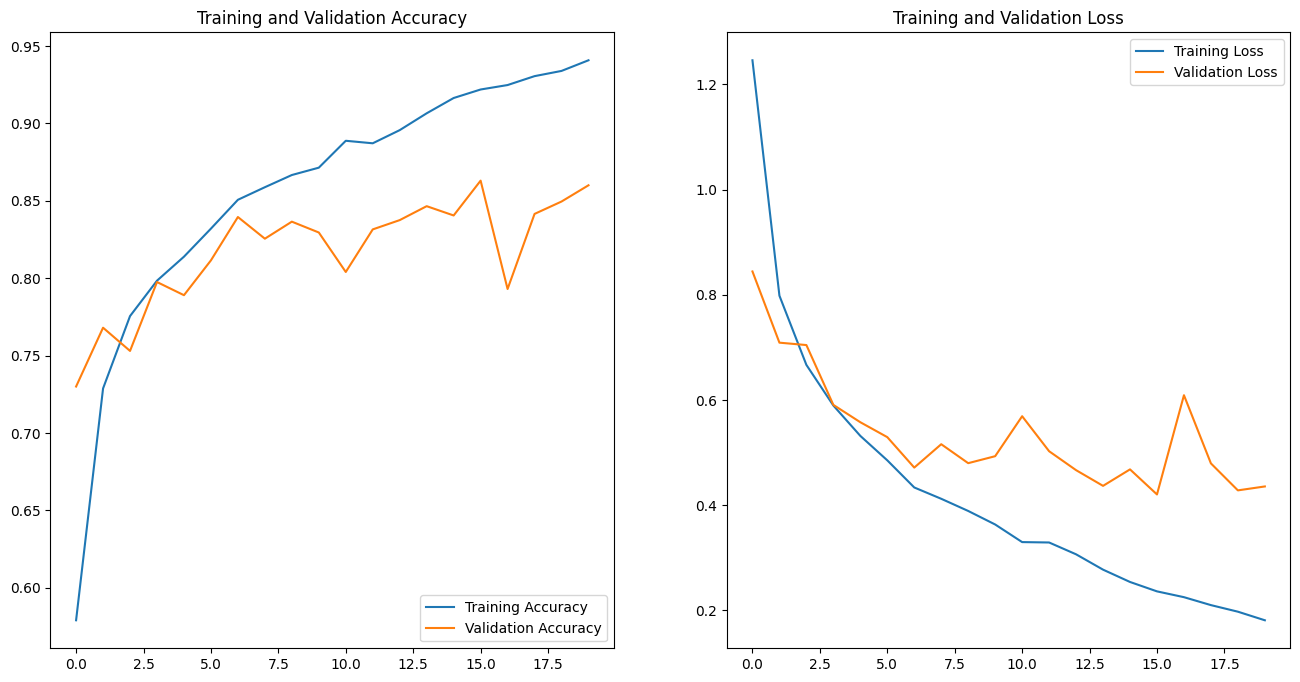

In [23]:

# Plot training and validation accuracy and loss
acc = transfer_history.history['accuracy']
val_acc = transfer_history.history['val_accuracy']
loss = transfer_history.history['loss']
val_loss = transfer_history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
# Save the entire transfer learning model
transfer_model.save('transfer_model.h5')
